## Loan Repayment Predict 貸款償還預測
- 來自LendingClub.com的公開數據。
- 分類並預測借款人是否全額償還貸款。

### 預測
- 信用評分 (FICO)
- 是否全額償還貸款 (not fully paid)

### 特徵定義
- credit.policy
    - 如果客戶符合LendingClub.com的信用承保標準則為 1 ，否則為 0。
- purpose
    - 貸款的目的（取值“信用卡式”，“債務重組”，“教育”，“重大收購”，“小企業”，和“所有其他”）。
- int.rate
    - 貸款的利率為期（租金為11％）將儲存為0.11）。
- installment
    - 如果貸款資助，則借款人所欠的每月分期付款。.
- log.annual.inc
    - 自我報告的借款人年收入的記錄.
- dti
    - 借款人的債務到收入率（債務金額除以年收入）.
- fico
    - 借款人的FICO信用評分.
- days.with.cr.line
    - 借款人有信用額度的天數.
- revol.bal
    - 借款人的週轉金餘額（信用卡結算週期結束時未付的金額）.
- revol.util
    - 借款人的週轉線利用率（相對於可用總額使用的信用額度的數量）。
- inq.last.6mths
    - 借款人在過去6個月內債權人的詢問人員。
- delinq.2yrs
    - 借款人已到期30天以上的次數是過去2年的付款。
- pub.rec
    - 借款人的貶損公共記錄（破產申請，稅務或判斷）。
- not.fully.paid
    - 沒有全額償還貸款

In [6]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import LabelEncoder # 用於特徵提取, 將數值資料轉為離散
from sklearn.preprocessing import MinMaxScaler

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 
# plt 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
# 忽略警告
import warnings
warnings.filterwarnings("ignore")
# 避開科學記號顯示數值
pd.set_option('display.float_format',lambda x:'%f' % x)

In [7]:
# 載入資料集
dataset = pd.read_csv('./data/Loan Repayment Predict/Loan_Repayment_Predict.csv')
dataset.head(5)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.118900,829.100000,11.350407,19.480000,737,5639.958333,28854,52.100000,0,0,0,0
1,1,credit_card,0.107100,228.220000,11.082143,14.290000,707,2760.000000,33623,76.700000,0,0,0,0
2,1,debt_consolidation,0.135700,366.860000,10.373491,11.630000,682,4710.000000,3511,25.600000,1,0,0,0
3,1,debt_consolidation,0.100800,162.340000,11.350407,8.100000,712,2699.958333,33667,73.200000,1,0,0,0
4,1,credit_card,0.142600,102.920000,11.299732,14.970000,667,4066.000000,4740,39.500000,0,1,0,0


#### 觀察資料

In [8]:
# 確認資料特徵類型
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


Text(0.5, 1.0, 'Total Missing Value (%) in Dataset')

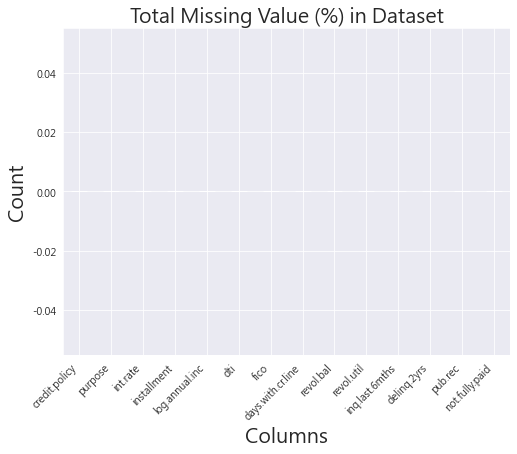

In [9]:
# 檢查缺失值
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# histogram
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%) in Dataset", fontsize = 20)